In [1]:
import torch
import torchvision 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
dataset = torchvision.datasets.EMNIST(root="../data", download=True, split="letters")
dataset

Dataset EMNIST
    Number of datapoints: 124800
    Root location: ../data
    Split: Train

In [4]:
X = dataset.data
Y = dataset.targets

In [5]:
len(dataset) * 0.8

99840.0

In [6]:
train_size = 99840
Xtrain = X[:train_size] /255
Ytrain = Y[:train_size]
Ytrain = Y[:train_size].unsqueeze(1)

Xtest = X[train_size:] /255
Ytest = Y[train_size:]
Ytest = Y[train_size:].unsqueeze(1)

In [7]:
ninput = 784
nhidden = 256
nhidden2 = 256
batch_size =1024
nclasses = len(dataset.classes)

In [8]:
W1 = torch.randn(ninput, nhidden, requires_grad=True) * torch.sqrt(torch.tensor(2.0) / (ninput + nhidden))
b1 = torch.randn(1, nhidden, requires_grad=True)
W2 = torch.randn(nhidden, nhidden2, requires_grad=True)* torch.sqrt(torch.tensor(2.0) / (nhidden + nhidden2))
b2 = torch.randn(1, nhidden2, requires_grad=True)
W3 = torch.randn(nhidden2, nclasses, requires_grad=True)* torch.sqrt(torch.tensor(2.0) / (nhidden + nhidden2))
b3 = torch.zeros(1, nclasses, requires_grad=True)

gamma1 = torch.ones((256,))
gamma2 = torch.ones((256,))
beta1 = torch.zeros((256,))
beta2 = torch.zeros((256,))

dropout_rate = 0.18
D1 = torch.FloatTensor(1, nhidden).uniform_(0, 1) > dropout_rate
D2 = torch.FloatTensor(1, nhidden2).uniform_(0, 1) > dropout_rate

In [9]:
num_batches = len(Xtrain) // batch_size

In [10]:
torch.cuda.empty_cache()

In [11]:
alpha = 0.1
losses = []
val_losses = []
epsilon = 1e-5
max_grad_norm = 0.01

# Move model and tensors to device
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)
W3 = W3.to(device)
b3 = b3.to(device)
D1 = D1.to(device)
D2 = D2.to(device)
gamma1 = gamma1.to(device)
gamma2 = gamma2.to(device)
beta1 = beta1.to(device)
beta2 = beta2.to(device)
Xtrain = Xtrain.to(device)
Ytrain = Ytrain.to(device)
Xtest = Xtest.to(device)
Ytest = Ytest.to(device)

for epoch in range(100):
    epoch_loss = 0.0
    for i in range(num_batches):
        # Create batch
        torch.cuda.empty_cache()
        
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = Xtrain[start_idx:end_idx]
        Y_batch = Ytrain[start_idx:end_idx]

        # Forward pass with batch normalization
        Z1 = X_batch.view(-1, ninput) @ W1 + b1
        mean1 = Z1.mean(dim=0, keepdim=True)
        var1 = Z1.var(dim=0, keepdim=True, unbiased=False)
        Z1_hat = (Z1 - mean1)/torch.sqrt(var1 + epsilon)
        Z1_bn = gamma1 * Z1_hat + beta1
        A1 = torch.tanh(Z1_bn)

         # Apply dropout to A1
        D1 = torch.FloatTensor(A1.size()).uniform_(0, 1).to(A1.device) > dropout_rate
        A1_drop = A1 * D1 / (1 - dropout_rate)  # Apply dropout
        
        Z2 = A1_drop @ W2 + b2
        mean2 = Z2.mean(dim=0, keepdim=True)
        var2 = Z2.var(dim=0, keepdim=True, unbiased=False)
        Z2_hat = (Z2 - mean2)/torch.sqrt(var2 + epsilon)
        Z2_bn = gamma2 * Z2_hat + beta2
        A2 = torch.tanh(Z2_bn)

        # Apply dropout to A2
        D2 = torch.FloatTensor(A2.size()).uniform_(0, 1).to(A1.device) > dropout_rate
        A2_drop = A2 * D2 / (1 - dropout_rate)  # Apply dropout
        
        Z3 = A2_drop @ W3 + b3
        zmax = Z3.max(dim=1, keepdim=True).values
        znorm = Z3 - zmax
        zexp = znorm.exp()
        zexp_sum = zexp.sum(dim=1, keepdim=True)
        zexp_sum_inv = zexp_sum ** (-1)
        probs = zexp * zexp_sum_inv
        log_probs = probs.log()
        L = -log_probs[torch.arange(len(Y_batch)), Y_batch.squeeze()].mean()
        epoch_loss += L.item()

        # for i in [zexp, zexp_sum, zexp_sum_inv, znorm, zmax, probs, log_probs, Z3, W3, b3, Z2, b2, W2, Z1, W1, b1, L]:
        #     i.retain_grad()
        # L.backward()

        # Backward pass
        dL_dL = torch.ones_like(L)
        dL_dlogprobs = torch.zeros_like(log_probs)
        dL_dlogprobs[torch.arange(len(Y_batch)), Y_batch.squeeze()] = -dL_dL / len(Y_batch)
        dL_dprobs = dL_dlogprobs * 1 / probs
        dL_dzexp = dL_dprobs * zexp_sum_inv
        dL_dzexp_sum_inv = (dL_dprobs * zexp).sum(1, keepdim=True)
        dL_dzexp_sum = -1 * dL_dzexp_sum_inv * zexp_sum**(-2)
        dL_dzexp += dL_dzexp_sum
        dL_dznorm = dL_dzexp * zexp.clone()
        dL_dzmax = -dL_dznorm.sum(1, keepdim=True)
        dL_dZ = dL_dznorm
        dL_dZ += torch.nn.functional.one_hot(Z3.max(dim=1).indices, nclasses) * dL_dzmax
        
        dL_dW3 = A2.T @ dL_dZ
        dL_db3 = dL_dZ.sum(0, keepdim=True)
        dL_dA2 = dL_dZ @ W3.T
        dL_dA2 = dL_dA2 * D2 / (1 - dropout_rate) 
        
        dL_dZ2_bn = dL_dA2 * (1 - A2**2)
        dL_dgamma2 = (dL_dZ2_bn * Z2_hat).sum(0)
        dL_dbeta2 = dL_dZ2_bn.sum(0)
        dL_dZ2_hat = dL_dZ2_bn * gamma2
        dL_dZ2 = dL_dZ2_hat / torch.sqrt(var2 + epsilon)
        dL_dvar2 = (dL_dZ2_hat * (Z2 - mean2) * -0.5 * (var2 + epsilon)**(-1.5)).sum(0)
        dL_dmean2 = (dL_dZ2_hat * (-1 / torch.sqrt(var2 + epsilon))).sum(0) + dL_dvar2 * ((-2 * (Z2 - mean2)).sum(0) / len(Z2)) 
        dL_dZ2 += ((dL_dvar2 * 2 * (Z2 - mean2)/len(Z2)) + dL_dmean2 * 1/len(Z2))
        dL_dA1 = dL_dZ2 @ W2.T
        dL_dA1 = dL_dA1 * D2 / (1 - dropout_rate) 
        
        dL_dZ1_bn = dL_dA1 * (1 - A1**2)
        dL_dgamma1 = (dL_dZ1_bn * Z1_hat).sum(0)
        dL_dbeta1 = dL_dZ1_bn.sum(0)
        dL_dZ1_hat = dL_dZ1_bn * gamma1
        dL_dZ1 = dL_dZ1_hat / torch.sqrt(var1 + epsilon)
        dL_dvar1 = (dL_dZ1_hat * (Z1 - mean1) * -0.5 * (var1 + epsilon)**(-1.5)).sum(0)
        dL_dmean1 = (dL_dZ1_hat * (-1 / torch.sqrt(var1 + epsilon))).sum(0) + dL_dvar1 * ((-2 * (Z1 - mean1)).sum(0) / len(Z1))
        dL_dZ1 += ((dL_dvar1 * 2 * (Z1 - mean1)/len(Z1)) + dL_dmean1 * 1/len(Z1))
        
        dL_dW2 = A1.T @ dL_dZ2
        dL_db2 = dL_dZ2.sum(0, keepdim=True)
        # dL_dA1 = dL_dZ2 @ W2.T
        # dL_dZ1 = dL_dA1 * (1 - A1**2)
        dL_dW1 = X_batch.view(-1, ninput).T @ dL_dZ1
        dL_db1 = dL_dZ1.sum(0, keepdim=True)

        torch.nn.utils.clip_grad_norm_([W1, b1, W2, b2, W3, b3], max_grad_norm)
        for param, grad in zip([W1, b1, W2, b2, W3, b3], [dL_dW1, dL_db1, dL_dW2, dL_db2, dL_dW3, dL_db3]):
            grad_norm = torch.norm(grad)
            if grad_norm > max_grad_norm:
                grad = grad / grad_norm * max_grad_norm

        with torch.no_grad():
            W1 -= alpha * dL_dW1
            b1 -= alpha * dL_db1
            W2 -= alpha * dL_dW2
            b2 -= alpha * dL_db2
            W3 -= alpha * dL_dW3
            b3 -= alpha * dL_db3
          
        # break
    # Calculate validation loss
    val_loss = 0.0
    # max_grad_norm = 1.0  # Set the maximum gradient norm
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    # with torch.no_grad():
    #     for j in range(len(Xtest) // batch_size):
    #         start_idx = j * batch_size
    #         end_idx = (j + 1) * batch_size
    #         X_val = Xtest[start_idx:end_idx]
    #         Y_val = Ytest[start_idx:end_idx]

    #         Z1_val = X_val.view(-1, ninput) @ W1 + b1
    #         A1_val = torch.tanh(Z1_val)
    #         Z2_val = A1_val @ W2 + b2
    #         A2_val = torch.tanh(Z2_val)
    #         Z3_val = A2_val @ W3 + b3
    #         val_loss += -torch.nn.functional.log_softmax(Z3_val, dim=1)[torch.arange(len(Y_val)), Y_val.squeeze()].mean().item()
    # val_loss /= (len(Xtest) // batch_size)

    # losses.append(epoch_loss / num_batches)
    # val_losses.append(val_loss)

    # print(f"Epoch {epoch}, Loss: {losses[-1]}, Validation Loss: {val_losses[-1]}")
    val_loss = 0.0
    with torch.no_grad():
        Z1_val = Xtest.view(-1, ninput) @ W1 + b1
        A1_val = torch.tanh(Z1_val)
        Z2_val = A1_val @ W2 + b2
        A2_val = torch.tanh(Z2_val)
        Z3_val = A2_val @ W3 + b3
        val_loss = -torch.nn.functional.log_softmax(Z3_val, dim=1)[torch.arange(len(Ytest)), Ytest.squeeze()].mean().item()

    losses.append(epoch_loss / num_batches)
    val_losses.append(val_loss)

    print(f"Epoch {epoch}, Loss: {losses[-1]}, Validation Loss: {val_losses[-1]}")

Epoch 0, Loss: 1.6488641426735318, Validation Loss: 2.765514612197876
Epoch 1, Loss: 1.1616681998537988, Validation Loss: 2.6773898601531982
Epoch 2, Loss: 1.0539848460364587, Validation Loss: 2.640085220336914
Epoch 3, Loss: 0.9909337623832152, Validation Loss: 2.6246461868286133
Epoch 4, Loss: 0.9406117950518107, Validation Loss: 2.6341516971588135
Epoch 5, Loss: 0.9017648242183567, Validation Loss: 2.6430695056915283
Epoch 6, Loss: 0.8668801778370572, Validation Loss: 2.674844264984131
Epoch 7, Loss: 0.8359866259024316, Validation Loss: 2.6724791526794434
Epoch 8, Loss: 0.8104555711303789, Validation Loss: 2.7030577659606934
Epoch 9, Loss: 0.7868572958965891, Validation Loss: 2.73860239982605
Epoch 10, Loss: 0.7666975143029517, Validation Loss: 2.770143508911133
Epoch 11, Loss: 0.7439986879063636, Validation Loss: 2.794480323791504
Epoch 12, Loss: 0.7287332532332116, Validation Loss: 2.8380744457244873
Epoch 13, Loss: 0.7134106970324958, Validation Loss: 2.8739664554595947
Epoch 14,

In [12]:
def compare_grad(s, dX, X):
    exact = torch.all(dX == X.grad).item()
    close = torch.allclose(dX, X.grad)
    maxdiff = (dX - X.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(exact):5s} | approximate:{str(close):5s} | maxdiff: {maxdiff}")

In [13]:
# compare_grad('logprobs', dL_dlogprobs, log_probs)
# compare_grad('probs', dL_dprobs, probs)
# compare_grad('zexp', dL_dzexp, zexp)
# compare_grad('zexp_sum_inv', dL_dzexp_sum_inv, zexp_sum_inv)
# compare_grad('zexp_sum', dL_dzexp_sum, zexp_sum)
# compare_grad('znorm', dL_dznorm, znorm)
# compare_grad('zmax', dL_dzmax, zmax)
# compare_grad('Z2', dL_dZ2, Z2)
# compare_grad('W2', dL_dW2, W2)
# compare_grad('b2', dL_db2, b2)
# compare_grad('Z1', dL_dZ1, Z1)
# compare_grad('W1', dL_dW1, W1)
# compare_grad('b1', dL_db1, b1)


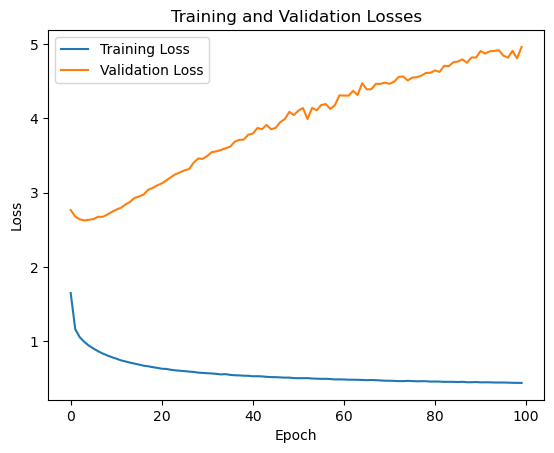

In [14]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [15]:
correct = 0
total = 0

with torch.no_grad():
    for i in range(len(Xtest)):
        Z1 = Xtest[i].view(1, -1) @ W1 + b1
        A1 = torch.tanh(Z1)
        Z2 = A1 @ W2 + b2
        A2 = torch.tanh(Z2)
        Z3 = A2 @ W3 + b3
        predicted_class = torch.argmax(Z3, dim=1)

        if predicted_class == Ytest[i]:
            correct += 1
        total += 1
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.17664262820512822
